# Introduction to Computational Science: Assignment 2
# Stochastic and Spatial Models
## Boyan Mihaylov & Sai Vinay Vardhan Daliparthi

This notebook documents the code used for the experiments conducted for Assignment 2 of the course "Introduction to Computational Science".

### Table of Contents
[0. Prerequisites](#0-prerequisites)  
[1. Implementation of Gillespie's Algorithm](#1-implementation-of-gillespies-algorithm)  
- [1.1. Deterministic Benchmark](#11-deterministic-benchmark)  
- [1.2. Stochastic SIR](#12-stochastic-sir)  
- [1.3. Parameter Influence on Stochastic Behaviour](#13-parameter-influence-on-stochastic-behaviour)  
- [1.4. Stochastic Resonance and Transients](#14-stochastic-resonance-and-transients)  
- [1.5. Extinction Events and Critical Community Size](#15-extinction-events-and-critical-community-size)  

[2. Network Model](#2-network-model)

<a id='Prerequisites'></a>
### 0. Prerequisites

The relevant libraries are imported below:

In [71]:
import math
from sympy import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import seaborn as sns
import pandas as pd

import networkx as nx
import ndlib.models.ModelConfig as mc
import ndlib.models.epidemics.SIRModel as sir
import ndlib.models.epidemics as ep
from bokeh.io import output_notebook, show
from ndlib.viz.bokeh.DiffusionTrend import DiffusionTrend
from ndlib.viz.bokeh.MultiPlot import MultiPlot
import random

output_notebook()

Loading BokehJS ...

The Fourth-order Runge-Kutta method will be implemented as default numerical integration scheme for the deterministic SIR variants:

In [4]:
def runge_kutta(fun, x, step):
        """Fourth order Runge-Kutta method
        """
        k1 = fun(x)*step
        k2 = fun(x+0.5*k1)*step
        k3 = fun(x+0.5*k2)*step
        k4 = fun(x+k3)*step
        return x + (k1+2*k2+2*k3+k4)/6

<a id='Gillespie'></a>
### 1. Implementation of Gillespie's Algorithm

<a id='Deterministic'></a>
### 1.1. Deterministic Benchmark
First, we recall the procedures used for the deterministic SIR model with demography which is implemented here as a Python class.

As a refresher, the characteristic ODEs for this system are:

$$
\frac{dS}{dt}=\mu-\beta S I - \mu S \\
\frac{dI}{dt}=\beta S I - \gamma I - \mu I \\
\frac{dR}{dt}=\gamma I - \mu R
$$

The parameters $\beta$, $\gamma$ and $\mu$ can be supplied during class initialization directly, or calculated in the following way:

$\beta = -\kappa \ln(1-C)$, where $\kappa$ is the number of individual contacts per unit time and $C$ is the probability of infection in the case of an infected contact.

$\gamma = 1/P_{inf}$ where $P_{inf}$ is the period of infection (in days).

$\mu = 1/L$, where $L$ is the expected lifespan of an individual (in years).

Both the deterministic and the stochastic model are implemented as Python classes that allow simulation of the disease spread over a given time span. The basic reproductive ratio is calculated internally and printed as a function of the basic parameters:

$$
R_0=\frac{\beta}{\gamma+\mu}
$$

In [5]:
class InfectionModelDeterministic:
    """Basic class for the deterministic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta, gamma and mu parameters can be provided directly
        or calculated via the parameters k, c, pinf and lifespan.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta and gamma depending on inputs
        if beta:
            self.beta=beta
        else:
            self.beta = -k*math.log(1-c)
        if gamma:
            self.gamma = gamma
        else:
            self.gamma = 1/pinf
        self.R0 = self.beta/self.gamma
        
        self.N = X+Y+Z
        self.S = X/self.N
        self.I = Y/self.N
        self.R = Z/self.N

        if mu:
            self.mu = mu
        else:
            self.mu = 1/lifespan
        
        self.R0 = self.beta/(self.gamma+self.mu)
        self.ode = self.SIR_d
    

    def SIR_d(self, sir):
        """Adds ODEs for demography model
        """
        
        self.dS = self.mu - self.beta*self.S*self.I - self.mu*self.S
        self.dI = self.beta*self.S*self.I - self.gamma*self.I - self.mu*self.I
        self.dR = self.gamma*self.I - self.mu*self.R
        
        return np.array([self.dS, self.dI, self.dR])
    
    
    def iterate(self, step, max_time, beta=None, gamma=None, constrain=True):
        """Numerical integration of the population fractions
        """
        
        # Assign native beta and gamma unless overriden
        if beta: self.beta = beta
        else: beta = self.beta
        if gamma: self.gamma = gamma
        else: gamma = self.gamma
        
        X_track = []
        Y_track = []
        Z_track = []
        time_track = []
        
        time_elapsed = 0
        while time_elapsed < max_time:
            
            # Constrain to range 0 to 1
            if constrain:
                if self.S < 0: self.S = 0
                elif self.S > 1: self.S = 1
                if self.I < 0: self.I = 0
                elif self.I > 1: self.I = 1
                if self.R < 0: self.R = 0
                elif self.R > 1: self.R = 1
            
            X_track.append(self.S*self.N)
            Y_track.append(self.I*self.N)
            Z_track.append(self.R*self.N)
            time_track.append(time_elapsed)
            self.S, self.I, self.R = runge_kutta(self.ode, np.array([self.S,self.I,self.R]),step)
            
            time_elapsed += step

        return time_track, X_track, Y_track, Z_track

<a id='StochasticSIR'></a>
### 1.2. Stochastic SIR

Next a new type of infection model class is constructed which implements Gillespie's Direct Algorithm.

The basic rate parameters $\beta$, $\gamma$ and $\mu$ are defined and stored in the same way as in the deterministic model. The population compartments will no more be represented by the fractions $S$, $I$ and $R$ but rather by the absolute numbers of individuals $X$, $Y$ and $Z$.

The possible events for the stochastic choice are listed in a dictionary together with their corresponding rates. Whenever a specific event is chosen for the current algorithm iteration, a designated procedure is conducted which updates the corresponding population department based on the type of event (as indicated by the selected dictionary key).

Gillespie's Direct Algorithm comprises the following steps:
- all possible events are labeled (in this case via the dictionary keys `'birth'`, `'transmission'`, `'recovery'`, `'deathX'`, `'deathY'`, `'deathZ'`);
- their rates are determined by the corresponding terms from the ODE's and stored as values in the dictionary; these rates are put in a defined order;
- the sum-total $R_T$ of all event rates is calculated;
- at each time-step in the process a random number $r_1$ from a uniform distribution is generated;
- the time until the next event is calculated as $\delta t = -\frac{1}{R_T}ln(r_1)$;
- a new random number $r_2$ is generated from a uniform distribution and multiplied with the total of the rates so that $P=r_2 R_T$;
- if $P$ falls between the values of two accumulated rates up to event $p$ ($\sum_{m=1}^{p-1}R_m < P < \sum_{m=1}^{p}R_m$), then the key for this event is chosen for the event execution and the time is updated with the step $\delta t$.

As a means to control the level of noise, the parameter `noise_lvl` is introduced which enables a probabilistic switch between a more regular sequence of events - defined as a periodically repeating series of numbers - and the uniformly distributed random numbers. The higher the noise parameter is set, the higher the probability for the random component to be selected. The periodic, quasi-deterministic pattern can be shifted at every run by a randomly set phase offset in order to precondition a smoothing of the stepped artifacts that may occur due to the sawtooth-shaped modulation. The range of the random phase offset is determined by the parameter `phase_range`.

In [69]:
class InfectionModelStochastic:
    """Basic class for the stochastic SIR model with demography
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function. Beta and gamma parameters can be provided directly
        or calculated via the parameters k, c and pinf.
        """
        
        #print("Infection model initiated with: \n" + str(X) + " susceptible\n" + str(Y) + " infected\n" + str(Z) + " recovered\n")
        
        # Calculate beta, gamma and mu depending on inputs
        if beta: self.beta=beta
        else: self.beta = -k*math.log(1-c)

        if gamma: self.gamma = gamma
        else: self.gamma = 1/pinf

        if mu: self.mu = mu
        else: self.mu = 1/lifespan
        
        # Assign population numbers
        self.X = X
        self.Y = Y
        self.Z = Z
        self.N = X+Y+Z
        
        # Calculate R0
        self.R0 = self.beta/(self.gamma+self.mu)

        # Define possible events and their starting rates
        self.events = {
            'birth': self.mu*self.N,
            'transmission': self.beta*self.X*self.Y/self.N,
            'recovery': self.gamma*self.Y,
            'deathX': self.mu*self.X,
            'deathY': self.mu*self.Y,
            'deathZ': self.mu*self.Z
        }
        
        # Assign iteration scheme
        self.iter_scheme = self.iteration_GDA
    

    def update_rates(self):
        """Updates event rates based on current population sizes.
        """

        self.events['birth'] = self.mu*self.N
        self.events['transmission'] = self.beta*self.X*self.Y/self.N
        self.events['recovery'] = self.gamma*self.Y
        self.events['deathX'] = self.mu*self.X
        self.events['deathY'] = self.mu*self.Y
        self.events['deathZ'] = self.mu*self.Z
    

    def update_population(self, event_key):
        """Updates compartment numbers based on selected event
        """

        if event_key == 'birth':
             self.X += 1
        elif event_key == 'transmission' and self.X > 0:
            self.X -= 1
            self.Y += 1
        elif event_key == 'recovery' and self.Y > 0:
            self.Y -= 1  
            self.Z += 1     
        elif event_key == 'deathX' and self.X > 0:
            self.X -= 1
        elif event_key == 'deathY' and self.Y > 0:
            self.Y -= 1
        elif event_key == 'deathZ' and self.Z > 0:
            self.Z -= 1
        
        self.N = self.X + self.Y + self.Z

        self.update_rates()


    def iteration_GDA(self, iter_ct, phase_offset, noise_lvl=1.0):
        """Performs a single event iteration of Gillespie's Direct Algorithm.
        """

        # The rate at which any event occurs
        self.rates_total = sum(self.events.values())

        # Interpolate between deterministic and stochastic component of time sequence
        det_comp = math.exp(-1)
        rand_comp = np.random.uniform(0, 1)
        if np.random.uniform(0, 1) < noise_lvl: rand_1 = rand_comp
        else: rand_1 = det_comp

        # Interpolate between deterministic and stochastic component of event sequence
        det_comp = (phase_offset + 0.1*iter_ct/len(self.events))%1.0
        rand_comp = np.random.uniform(0, 1)
        if np.random.uniform(0, 1) < noise_lvl: rand_2 = rand_comp
        else: rand_2 = det_comp

        # Time until next event
        dt = -math.log(rand_1)/self.rates_total

        # Event selector
        event_sel = rand_2*self.rates_total

        # Pick event using selector
        running_sum = 0
        selected_key = None
        for event_key in self.events:
            if event_sel > running_sum and event_sel <= running_sum + self.events[event_key]:
                selected_key = event_key
                break
            running_sum += self.events[event_key]

        # Perform event
        self.update_population(selected_key)

        # Return time step
        return dt


    def iterate(self, maxtime, noise_lvl=1.0, phase_range=0.0):
        """Performs multiple iterations of stochastic algorithm
        over a specified time frame.
        """

        time_current = 0
        iter_ct = 0
        max_iter = 10e9

        time_track = []
        X_track = []
        Y_track = []
        Z_track = []
        N_track = []

        while time_current < maxtime and iter_ct < max_iter:

            # Track values
            time_track.append(time_current)
            X_track.append(self.X)
            Y_track.append(self.Y)
            Z_track.append(self.Z)
            N_track.append(self.N)

            # Set a random phase offset for the periodic event pattern
            phase_offset = np.random.uniform(0, phase_range*math.pi)

            # Perform single event step
            dt = self.iter_scheme(iter_ct, phase_offset, noise_lvl)

            time_current += dt
            iter_ct += 1
        
        if iter_ct == max_iter: print(f"Simulation hit iteration limit at time {time_current}.")

        return time_track, X_track, Y_track, Z_track, N_track

Below is an illustration of the quasi-deterministic and stochastic patterns as well as the probabilistic blend between them:

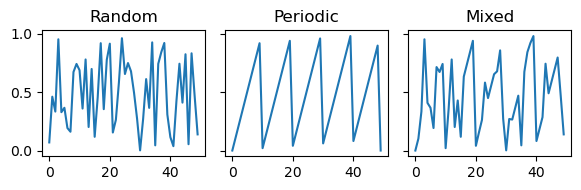

In [95]:
x_random = np.random.uniform(0, 1, 50)
x_periodic = (np.linspace(0, 5, 50))%1.0
x_mix = np.empty(shape=x_random.shape)

for i in range(x_random.shape[0]):
    if np.random.uniform(0,1) > 0.5:
        x_mix[i] = x_random[i]
    else:
        x_mix[i] = x_periodic[i]

fig, axs = plt.subplots(1, 3, sharex=True, sharey=True)
axs[0].plot(x_random)
axs[1].plot(x_periodic)
axs[2].plot(x_mix)
axs[0].set_title('Random')
axs[1].set_title('Periodic')
axs[2].set_title('Mixed')
fig.set_size_inches(6,2)
fig.tight_layout()
plt.show()

The stochasic model can now be put into use in a first test run. We are using the following parameter values:

$$
\kappa = 8\\
C = 0.1\\
P_{inf} = 7\\
L = 60
$$

Definitions in literature measure the period of infection in days and the expected lifespan in years. Here we set the former to one week and the latter to 60 years.

A time limit of 120 days is set for the simulation. Furthermore, to capture a broader picture of the behaviour of the system, 50 separate runs are simultaneously plotted using different random seeds. To align the time-grids of all plots and overcome the issue of inconsistent time-steps, the traced values are re-sampled using a quarter-day grid. This facilitates the visualisation of the error margin within the collection of runs.

In the following experiment the initial state comprises a single infected person versus the rest of the population being susceptible. For later experiments, the plotting function includes the option to calculate the deterministic model and plot its results for comparison, while also calculating the characteristic oscillation period resulting from the model parameters. This period is calculated as:

$$
T=2\pi\sqrt{AG}
$$

Where $A=\frac{1}{\mu(R_0-1)}$ stands for the mean age of infection and $G=\frac{1}{\mu+\gamma}$ represents the typical infectivity period for a host.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


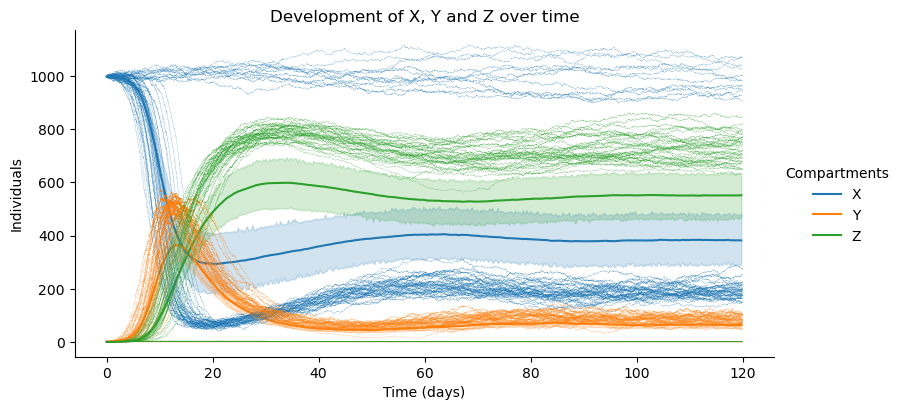

In [42]:
def plot_stochastic_model(maxtime, X_start, Y_start, Z_start, seed_max, title_add='', noise_lvl=1.0, phase_range=0.0, plot_det=False, **model_params):
    """Creates an instance of InfectionModelStochastic
    and plots the development of the X, Y and Z compartment over the predefined time.
    Includes an option to plot a corresponding deterministic model as a reference
    """

    # Range of random seeds
    seed_range = np.arange(0, seed_max, 1)

    # DataFrame for storing data from runs
    array_runs = np.array([[seed_range[0], 0, X_start, Y_start, Z_start]]).T
    array_runs_interp = array_runs[:]

    # Resample time in quarter-day intervals
    time_resample = np.arange(0, maxtime, 0.25)

    for s in seed_range:
        
        np.random.seed(s)

        #stochastic_SIR = InfectionModelStochastic(X_start, Y_start, Z_start, k=8, c=0.1, pinf=7, lifespan=16107.525)
        stochastic_SIR = InfectionModelStochastic(X_start, Y_start, Z_start,
                                                  k=model_params['k'], c=model_params['c'],
                                                  pinf=model_params['pinf'], lifespan=model_params['lifespan'],
                                                  beta=model_params['beta'], gamma=model_params['gamma'])

        time_track, X_track, Y_track, Z_track, _ = stochastic_SIR.iterate(maxtime, noise_lvl, phase_range)

        values_track = np.vstack([time_track, X_track, Y_track, Z_track])
        values_head = np.full([1,values_track.shape[1]], s)
        array_runs = np.append(array_runs, np.concatenate((values_head, values_track), axis=0), axis=1)

        # Interpolate (resample) values
        X_interp = np.interp(time_resample, time_track, X_track)
        Y_interp = np.interp(time_resample, time_track, Y_track)
        Z_interp = np.interp(time_resample, time_track, Z_track)
        values_interp = np.vstack([time_resample, X_interp, Y_interp, Z_interp])
        values_interp_head = np.full([1,values_interp.shape[1]], s)
        array_runs_interp = np.append(array_runs_interp, np.concatenate((values_interp_head, values_interp), axis=0), axis=1)

    print(f"R_0 = {stochastic_SIR.R0}")
    print(f"beta = {stochastic_SIR.beta}")
    print(f"gamma = {stochastic_SIR.gamma}")
    print(f"mu = {stochastic_SIR.mu}")

    # Construct DataFrames
    if plot_det:

        # Initialize and run deterministic model
        step = 10e-3
        deterministic_SIR = InfectionModelDeterministic(X_start, Y_start, Z_start,
                                                        k=model_params['k'], c=model_params['c'],
                                                        pinf=model_params['pinf'], lifespan=model_params['lifespan'],
                                                        beta=model_params['beta'], gamma=model_params['gamma'])
        values_track = np.vstack(deterministic_SIR.iterate(step, maxtime))
        df_runs = pd.DataFrame(values_track.T, columns=['time','$X_d$','$Y_d$','$Z_d$'])
        df_runs_melt = df_runs.melt('time', var_name='Compartments', value_name='vals')

        # Calculate and print oscillation period
        a = 1/(deterministic_SIR.mu*(deterministic_SIR.R0-1))
        g = 1/(deterministic_SIR.mu+deterministic_SIR.gamma)
        omega = 1/sqrt(a*g)
        print(f"Oscillation period for demographic SIR: {2*math.pi/omega} days")

    else:
        df_runs = pd.DataFrame(array_runs.T, columns=['seed','time','$X$','$Y$','$Z$'])
        df_runs_melt = df_runs.melt(['time','seed'], var_name='Compartments', value_name='vals')
    
    df_runs_interp = pd.DataFrame(array_runs_interp.T, columns=['seed','time','X','Y','Z'])
    df_runs_interp_melt = df_runs_interp.melt(['time','seed'], var_name='Compartments', value_name='vals')

    # Plot aggregation of stochastic runs (mean + sd)
    sns.relplot(df_runs_interp_melt, x='time', y='vals', kind='line', hue='Compartments', height=4, aspect=2.)

    # Plot either separate stochastic runs or deterministic run
    if plot_det: sns.lineplot(df_runs_melt, x='time', y='vals', hue='Compartments', palette='Set2', legend=False, dashes=[5,5])
    else: sns.lineplot(df_runs_melt, x='time', y='vals', hue='Compartments', style='seed', legend=False, linewidth=0.2)
    plt.xlabel('Time (days)')
    plt.ylabel('Individuals')
    plt.title('Development of X, Y and Z over time'+title_add)
    plt.show()


# Global simulation parameters
maxtime = 120 # days
X_start = 999
Y_start = 1
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None, mu=None)

Several observations can be made:
- Generally, consistent equilibria are present, with the compartment numbers oscillating around these;
- The distributions get skewed by occasional extinctions of the disease;
- The timing of the peak of infection exhibits some variation.

In order to prevent extinction of the pathogen before the infectious outbreak, one can examine a situation with more than one initial infected - in this case one percent of the population or 10 people. Additionally, the plot will be overlaid with the results from the deterministic counterpart of the model.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


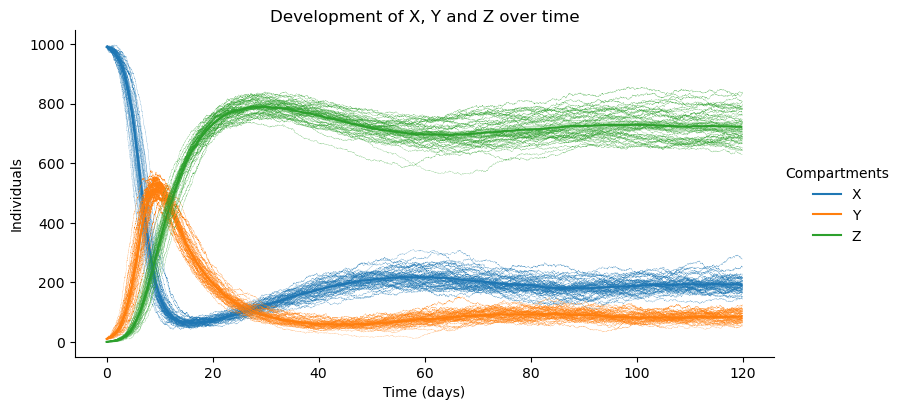

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666
Oscillation period for demographic SIR: 58.8749587939308 days


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


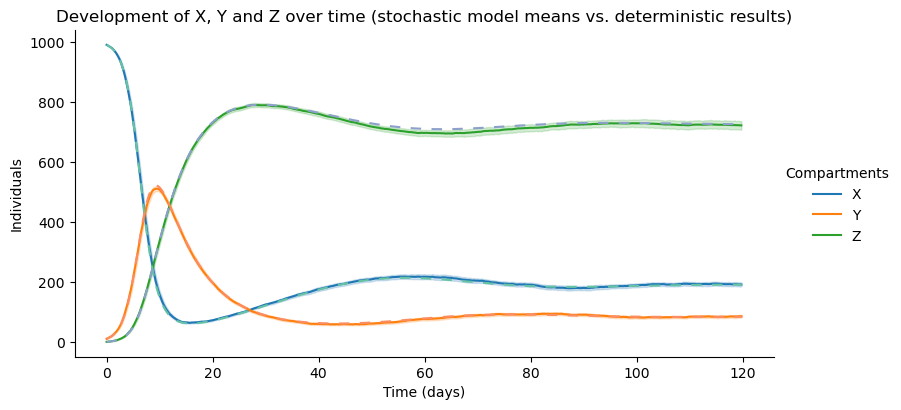

In [44]:
# Global simulation parameters
maxtime = 120 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, plot_det=False,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)
plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (stochastic model means vs. deterministic results)', plot_det=True,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

Noticeably, this narrows down the standard deviation of the 50 runs and presents more aligned trajectories.

Next, the effect of the noise control is explored by testing three configurations of the noise control parameters:
- an equal mix of the deterministic periodic pattern and the stochastic behaviour (`noise_lvl = 0.5`) and a small range for the random phase offset of the periodic pattern (`phase_range = 0.1`);
- a fully deterministic pattern (`noise_lvl = 0.0`) with a slight phase offset (`phase_range = 0.1`).
- a fully deterministic pattern (`noise_lvl = 0.0`) with a maximum phase offset range (`phase_range = 1.0`). The smoothing caused by the averaging of the time-displaced patterns is compared to the result curves of the deterministic model.

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


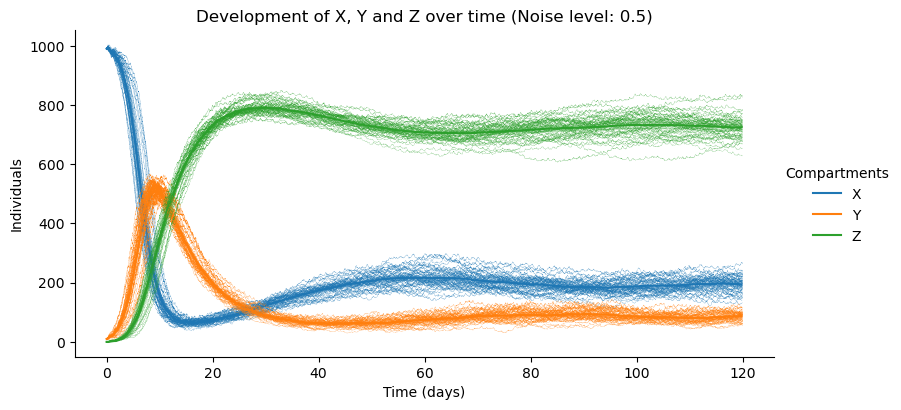

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


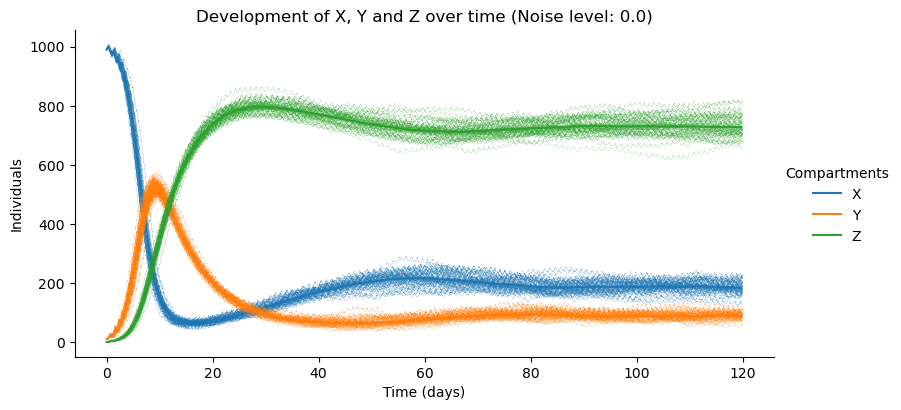

R_0 = 5.283751232989498
beta = 0.8428841252626103
gamma = 0.14285714285714285
mu = 0.016666666666666666


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


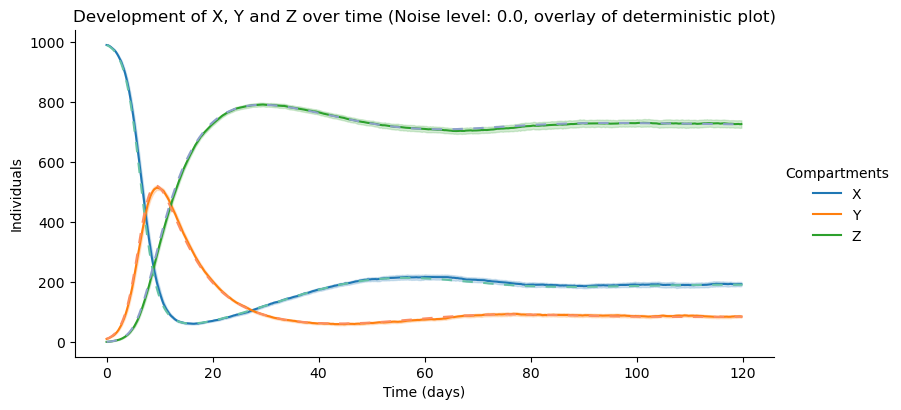

In [103]:
# Global simulation parameters
maxtime = 120 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.5)', noise_lvl=0.5, phase_range=0.1,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.0)', noise_lvl=0.0, phase_range=0.1, plot_det=False,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, ' (Noise level: 0.0, overlay of deterministic plot)', noise_lvl=0.0, phase_range=1.0, plot_det=True,
                      k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None)

Observing the separate runs of the stochastic model with completely removed noise (up to the phase offset of the periodic pattern) reveals the sawtooth-like fluctuations resulting from the fact that only one event can be executed within a discrete time moment.

The overlay of the results from the deterministic model shows significant alignment with the means of the stochastic model at all introduced levels of noise.

<a id='ParamStochastic'></a>
### 1.3. Parameter Influence on Stochastic Behaviour

The following parameters are inspected for their effect on the variance between runs, the co-variance between susceptible and infected, the stochastic resonance around the equilibrium and the extinction events:
- the population size;
- the initial number of infected individuals $Y_0$;
- the infection rate $\beta$;
- the recovery rate $\gamma$;
- the demographic rate $\mu$.

The previously tested configuration of parameters is used as a baseline for the default parameter values. Only the parameter of interest is incrementally varied. To take into account the dimension of time in the statistical analysis, a simulation period of one year is split into four quarter-year compartments so that the average variance and covariance per compartment can be analysed separately.

The setup per parameter value is run 50 times to capture different outcomes. Again, the simulation results are re-sampled by interpolation to arrays with a common size.

The method takes two Python dictionaries - one with the ranges of parameter values that are to be explored and one with the default parameter values for their fixed state.

**WARNING: The code below executes many simulations, the calculations may take a very long time!**

Analysing parameter N
Analysing parameter Y(0)
Analysing parameter beta
Analysing parameter gamma
Analysing parameter mu


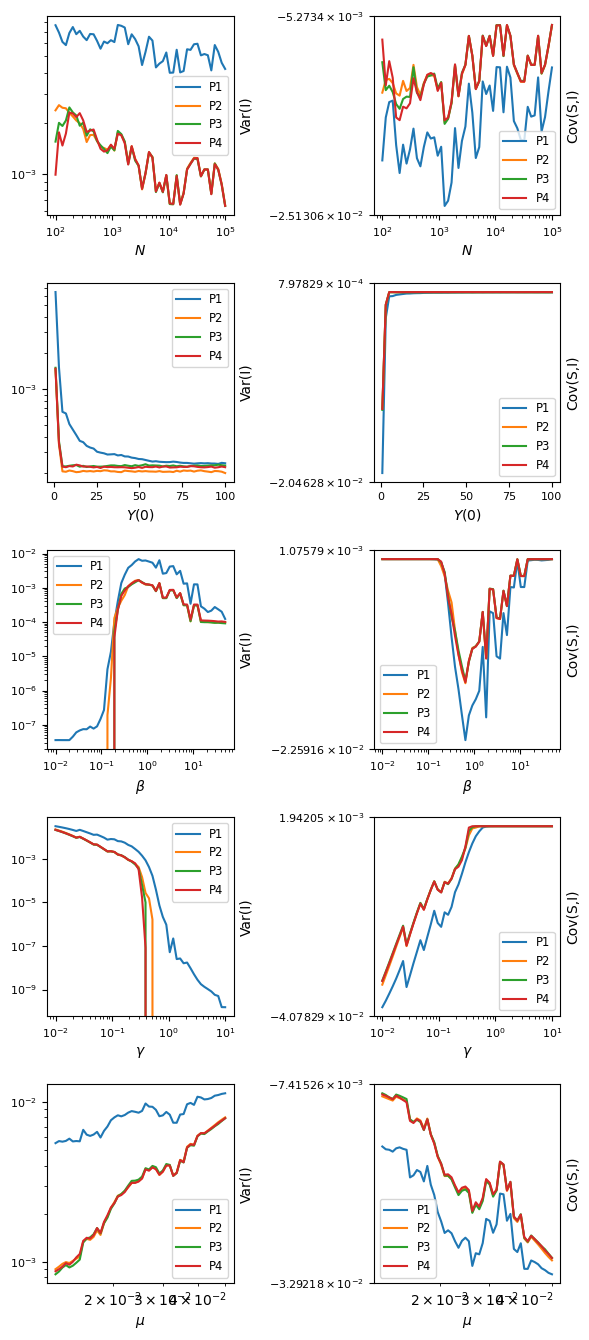

In [36]:
def analyse_var_cov(maxtime, n_runs, n_time_periods, n_periods_plot, *params_default_and_analysed):
    """Initialise and run multiple realisations of stochastic infection model with given ranges of parameters.
    Plot the resulting analysis of variances and covariances in a grid.
    The args  *params contains a list of two dictionaries containing (1) the range of values to be analysed and
    (2) the default parameter values
    """

    params = params_default_and_analysed[0]
    defaults = params_default_and_analysed[1]

    param_keys = list(params.keys())

    # Resample time in quarter-day intervals
    time_resample = np.arange(0, maxtime, 0.25)

    ax_width = 3
    fig, axs = plt.subplots(len(params), 2)
    fig.set_size_inches(ax_width*2, len(params)*0.9*ax_width)

    param_key_ct = 0
    for param in params:

        print(f"Analysing parameter {param}")

        S_var_period_means = np.empty((params[param].shape[0], n_time_periods))
        I_var_period_means = np.empty((params[param].shape[0], n_time_periods))
        SI_cov_period_means = np.empty((params[param].shape[0], n_time_periods))

        param_ct = 0
        for param_value in params[param]:

            S_grid = np.empty((n_runs, time_resample.shape[0]))
            I_grid = np.empty((n_runs, time_resample.shape[0]))

            # Set model parameters
            if param == 'N':
                n_pop = int(param_value)
                scales = ['log', 'log', 'symlog']
            else:
                n_pop = defaults['n_def']
            if param == 'Y(0)':
                Y_start = int(param_value)
                scales = ['linear', 'log', 'symlog']
            else:
                Y_start = defaults['Y0_def']
            if param == 'beta':
                beta = param_value
                scales = ['log', 'log', 'symlog']
            else:
                beta = None
            if param == 'gamma':
                gamma = param_value
                scales = ['log', 'log', 'symlog']
            else:
                gamma = None
            if param == 'mu':
                mu = param_value
                scales = ['log', 'log', 'symlog']
            else:
                mu = None
            if param == 'Infectious Period':
                pinf = param_value
                scales = ['linear', 'linear', 'linear']
            else:
                pinf = defaults['pinf_def']
            if param == 'Lifespan':
                lifespan = param_value
                scales = ['linear', 'linear', 'linear']
            else:
                lifespan = defaults['lspan_def']
            
            # Perform multiple realizations of stochastic model
            for s in range(n_runs):
                
                np.random.seed(s)

                # Create model instance
                stochastic_SIR = InfectionModelStochastic(n_pop - Y_start, Y_start, 0,
                                                          k=defaults['k_def'], c=defaults['c_def'], pinf=pinf, lifespan=lifespan,
                                                          beta=beta, gamma=gamma, mu=mu)

                # Run model
                time_track, X_track, Y_track, Z_track, N_track = stochastic_SIR.iterate(maxtime)
                # print(f"Final population size: {stochastic_SIR.N}")
                
                # Normalize X, Y and Z to S, I and R
                S_track = [X_track[i] / N_track[i] for i in range(len(N_track))]
                I_track = [Y_track[i] / N_track[i] for i in range(len(N_track))]
                
                # Interpolate (resample) values
                S_interp = np.interp(time_resample, time_track, S_track)
                I_interp = np.interp(time_resample, time_track, I_track)

                S_grid[s] = S_interp
                I_grid[s] = I_interp

            S_variances = np.var(S_grid, axis=0)
            I_variances = np.var(I_grid, axis=0)
            S_means = np.mean(S_grid, axis=0)
            I_means = np.mean(I_grid, axis=0)
            SI_covariances = np.mean((S_grid - S_means)*(I_grid - I_means), axis=0)

            # Split in time compartments and calculate compartment means
            S_var_periods = np.split(S_variances, n_time_periods)
            I_var_periods = np.split(I_variances, n_time_periods)
            SI_cov_periods = np.split(SI_covariances, n_time_periods)
            S_var_period_means[param_ct] = np.mean(I_var_periods, axis=1)
            I_var_period_means[param_ct] = np.mean(I_var_periods, axis=1)
            SI_cov_period_means[param_ct] = np.mean(SI_cov_periods, axis=1)

            param_ct += 1

        if param == 'beta' or param == 'gamma' or param == 'mu': xlabel = "$\\" + param_keys[param_key_ct] + "$"
        else: xlabel = "$" + param_keys[param_key_ct] + "$"
        
        for i in range(n_periods_plot):
            axs[param_key_ct][0].plot(params[param], I_var_period_means.T[i], label=f"P{i+1}")
            axs[param_key_ct][1].plot(params[param], SI_cov_period_means.T[i], label=f"P{i+1}")
            

        axs[param_key_ct][0].set_xlabel(xlabel)
        axs[param_key_ct][0].set_ylabel('Var(I)')
        axs[param_key_ct][0].yaxis.set_label_position("right")
        axs[param_key_ct][0].set_xscale(scales[0])
        axs[param_key_ct][0].set_yscale(scales[1])
        axs[param_key_ct][0].legend(fontsize='small')
        axs[param_key_ct][0].tick_params(axis='x', labelsize=8)
        axs[param_key_ct][0].tick_params(axis='y', labelsize=8)

        axs[param_key_ct][1].set_xlabel(xlabel)
        axs[param_key_ct][1].set_ylabel('Cov(S,I)')
        axs[param_key_ct][1].yaxis.set_label_position("right")
        axs[param_key_ct][1].set_xscale(scales[0])
        axs[param_key_ct][1].set_yscale(scales[2])
        axs[param_key_ct][1].legend(fontsize='small')
        axs[param_key_ct][1].tick_params(axis='x', labelsize=8)
        axs[param_key_ct][1].tick_params(axis='y', labelsize=8)

        param_key_ct += 1

    plt.tight_layout()

# Global simulation parameters
maxtime = 364 # approx 1 year (divisible by 4)
n_runs = 50
n_param_samples = 50
n_time_periods = 4
n_periods_plot = 4

# Dictionary of parameter values
params = {
    'N': np.geomspace(100, 100000, n_param_samples),
    'Y(0)': np.linspace(1, 100, n_param_samples),
    'beta': np.geomspace(0.01, 50, n_param_samples),
    'gamma': np.geomspace(0.01, 10, n_param_samples),
    'mu': np.geomspace(1/80, 1/20, n_param_samples),
    # 'Infectious Period': np.linspace(0.1, 100, n_param_samples),
    # 'Lifespan': np.linspace(20, 80, n_param_samples)
}

defaults = {
    'n_def': 1000,
    'Y0_def': 1,
    'k_def': 8,
    'c_def': 0.1,
    'pinf_def': 7,
    'lspan_def': 60
}

analyse_var_cov(maxtime, n_runs, n_time_periods, n_periods_plot, params, defaults)

The results from the different time compartments clearly highlight the difference between the first period, which captures the initial transient at the onset of the epidemic, and the three subsequent stages when the system approaches an oscillating equilibrium.

When observing the changes in a single parameter, its effect on the system happens not only directly, but also through the interaction with other fixed parameters. Therefore, the above experiment will be repeated using a different default setting. First the SIR model is re-tuned with the following parameters:

$$
\kappa = 12\\
C = 0.2\\
P_{inf} = 3\\
L = 80
$$

And the resulting infection curves from 50 realisations are plotted together with the deterministic model results:

R_0 = 7.742812382950891
beta = 2.6777226157705165
gamma = 0.3333333333333333
mu = 0.0125


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


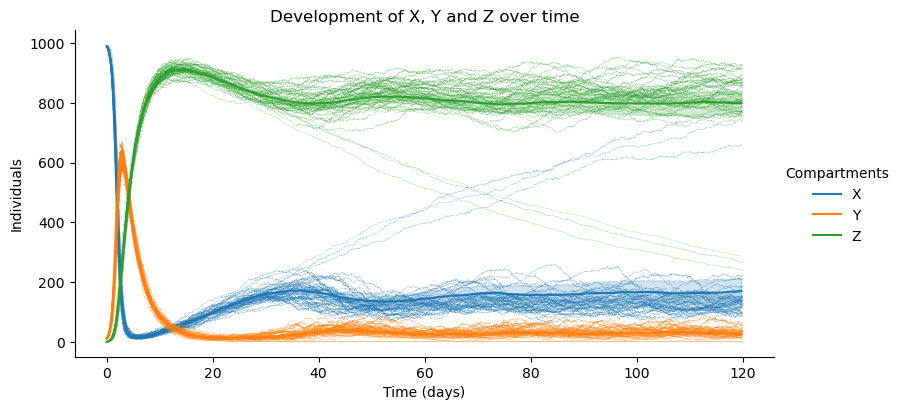

R_0 = 7.742812382950891
beta = 2.6777226157705165
gamma = 0.3333333333333333
mu = 0.0125
Oscillation period for demographic SIR: 36.8019557382083 days


c:\Users\mihbo\anaconda3\Lib\site-packages\seaborn\axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


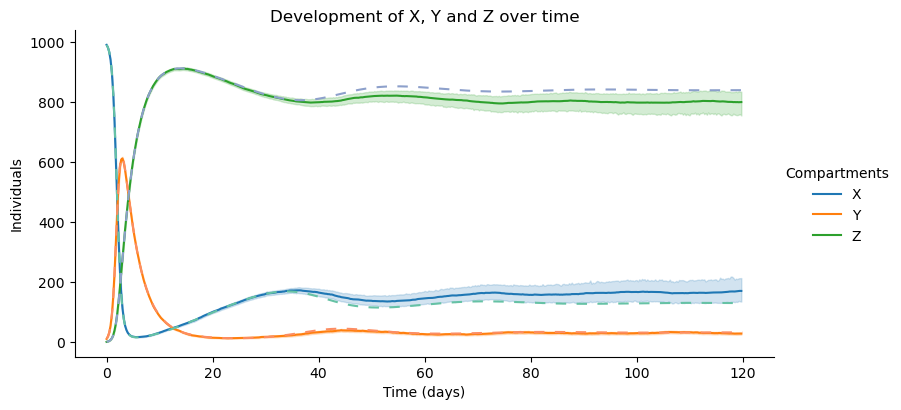

In [43]:
# Global simulation parameters
maxtime = 120 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, plot_det=False,
                      k=12, c=0.2, pinf=3, lifespan=80, beta=None, gamma=None)
plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, plot_det=True,
                      k=12, c=0.2, pinf=3, lifespan=80, beta=None, gamma=None)

Due to the higher $\beta$ and $\gamma$ values the epidemic burnout is now quicker, leading to a lower equilibrium of infected and thus visible occurences of extinction even at the increased initial number of infected. Additionally, the oscillation period is now shorter. The next step is to examine how this setting affects the stochastic behaviour under parameter variation:

Analysing parameter N
Analysing parameter Y(0)
Analysing parameter beta
Analysing parameter gamma
Analysing parameter mu


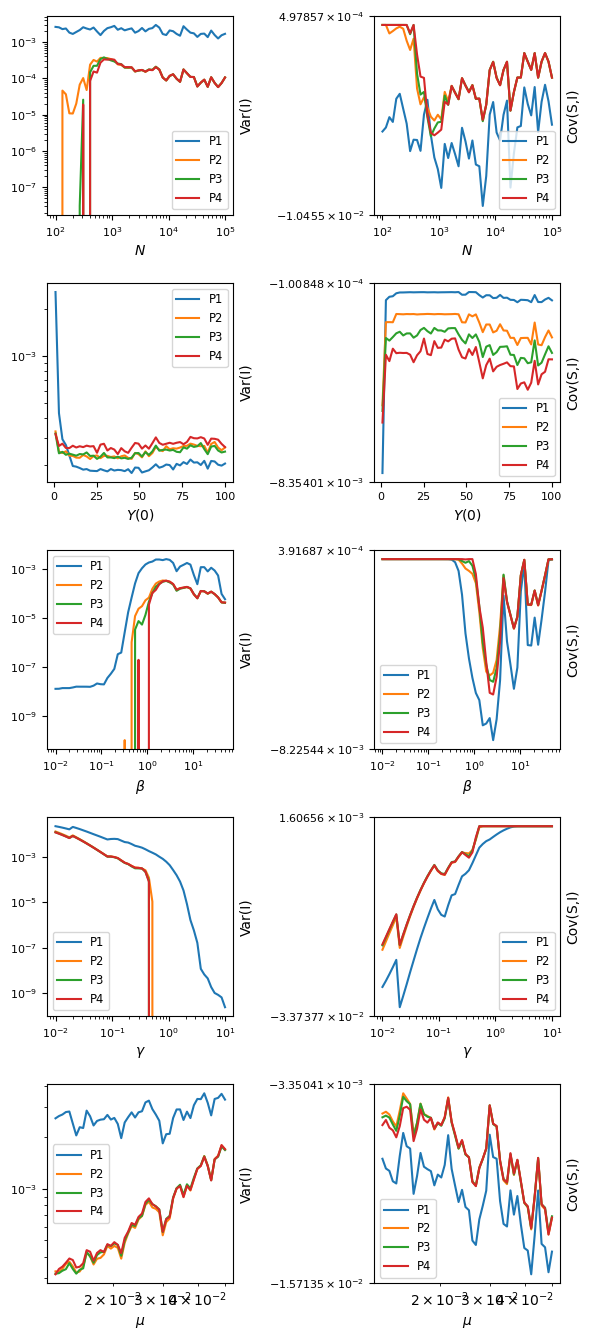

In [45]:
# Global simulation parameters
maxtime = 364 # approx 1 year (divisible by 4)
n_runs = 50
n_param_samples = 50
n_time_periods = 4
n_periods_plot = 4

# Dictionary of parameter values
params = {
    'N': np.geomspace(100, 100000, n_param_samples),
    'Y(0)': np.linspace(1, 100, n_param_samples),
    'beta': np.geomspace(0.01, 50, n_param_samples),
    'gamma': np.geomspace(0.01, 10, n_param_samples),
    'mu': np.geomspace(1/80, 1/20, n_param_samples),
    # 'Infectious Period': np.linspace(0.1, 100, n_param_samples),
    # 'Lifespan': np.linspace(20, 80, n_param_samples)
}

defaults = {
    'n_def': 1000,
    'Y0_def': 1,
    'k_def': 12,
    'c_def': 0.2,
    'pinf_def': 3,
    'lspan_def': 80
}

analyse_var_cov(maxtime, n_runs, n_time_periods, n_periods_plot, params, defaults)

The following observations can be made for both experiments:
- With increasing population the variance decreases, while the covariance exhibits an upward trend, while still remaining negative. In the first period the variance is higher and the covariance lower compared to the other time compartments. The relationship in all cases could be categorised as approximately linear. The most noteable difference between the different time compartments occurs at a low population size, with the variance gradually decreasing and the covariance increasing towards the end of the simulation, possibly due to the higher likelyhood of extinction within the observed period;
- When increasing the initial number of infected individuals the variance undergoes decrease. The variance and the respective negative covariance are most pronounced in the first period, at low $Y(0)$. The increased probability of extinction observed earlier in such cases might offer an explanation for this, as extinct diseases broadens the distribution of outcomes. A noticeable difference in the second experiment is that after the initial sharp increase in variance the trend seems to gradually climb back up, the covariance following the same pattern with a reversed sign. This may be a consequence of stochastic resonance caused by the second overall parameter setting being further activated through high $Y(0)$ values.
- The analysis of $\beta$ helps identify four stages of change. For low infection rates ($\beta < 0.1$) both the variance and the covariance are close to zero, hinting on the fact that the disease died out before resulting in spread. Roughly within the range ($0.1 < \beta < 1.0$) there is a steep increase in variance and a steep, linear decrease in negative covariance. For larger values of $\beta$ there is a similar variable increase for the variance and decrease for the covariance as in the previous studies. For sufficiently high values of $\beta$ the two statistical measures flatten out to a more constant value, especially in the later time periods. The reasons for this are harder to pinpoint without a more thorough analysis of the dependencies.
- Increasing values of $\gamma$ induce decreasing variance and increasing covariance, with the covariance reacing a plateau at a lower threshold than the variance. Thus, for very short infection periods the covariance between $S$ and $I$ is close to zero, implying that there is no more identifiable relationship between $S$ and $I$. Whether that is through loss of $I$ due to overwhelmingly fast recovery is to be verified. An interesting artifact that appears in the results of both experiments are some periodic peaks and valleys along the axis of the parameter. Since $\gamma$ is involved in the frequency term for the equilibrium oscillations and there are only a few undulations observable within the given time frame, this might be hinting on a certain bias caused by the incidence of peaks and valleys at specific moments in the time intervals. A more conclusive test could be performed by observing a much longer time span.
- Despite being also involved in the calculation of the oscillation frequency, the parameter $\mu$ does not to exhibit similar distinct patterns as $\gamma$. A consistent feature that appears in both experiments, however, is a local peak in covariances just above 0.03, corresponding to a life expectancy of about 33 years. The causes for this might be complex and are to be further investigated.

<a id='ResonanceTransients'></a>
### 1.4. Stochastic Resonance and Transients

The plots examined so far deliver some important insights about the oscillatory behaviour of the stochastic model close to its equilibrium point. Looking at the mean values of the stochastic realisations, they usually correspond closely to the deterministic plots when no early extinctions are present. However, it also becomes apparent that the standard deviation of the stochastic runs is larger in the period when the system has entered its oscillatory state. This could be explained by stochastic resonance, a phenomenon resulting from the shifting dominance of noise and deterministic behaviour. When the system is closed to the equilibrium state the relative influence of noise increases and it "excites" the trajectories away from their stable states in transient periods. On the other hand, when far away from the equilibrium, the deterministic forces prevail over the noise and the system exhibits a more predictable behaviour.

Examining the statistical parameter studies, some indications related to this issue can be identified: ????????????????

To gain a better understanding of the long-term development of stochastic resonance and transients, a longer time-span of the infection needs to be observed first. A period of 10 years is chosen for this, examining 50 realisations of the stochastic model. The parameters of the model are set back to their initial setting, yielding a higher value of infected individuals at the equilibrium and thus less likelihood of extinction.

R_0 = 3.9665135306475774
beta = 0.8428841252626103
gamma = 0.2
mu = 0.0125


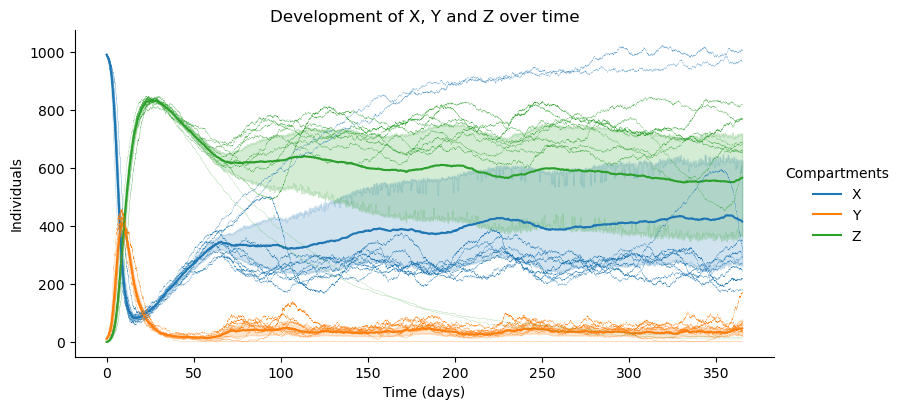

In [7]:
# Global simulation parameters
maxtime = 365.25 # days
X_start = 990
Y_start = 10
Z_start = 0

plot_stochastic_model(maxtime, X_start, Y_start, Z_start, 50, k=8, c=0.1, pinf=7, lifespan=60, beta=None, gamma=None, mu=None)

<a id='Extinction'></a>
### 1.5. Extinction Events and Critical Community Size

It was previously observed that some typical causes for disease extinction are:
- the initial number of infected;
- the proximity of the infected equilibrium to zero. Considering that this equilibrium is defined by $\frac{\mu}{\beta}(R_0-1)$, this implies the joint influence of $\beta$, $\gamma$ and $\mu$.

In the following experiment a more systematic analysis of the effects on different parameters on the extinction likelihood is performed. Due to their discrete nature, stochastic models inherently precondition a chance of disease extinction, given sufficient time (when $Y$ reaches a value of one and subsequently zero). Therefore, in order to be able to quantify the predisposition of the system to extinction, a mechanism for importing infected individuals into the population must be introduced.

There are two methods of doing this, suggested in Keeling and Rohani (2007). One corresponds to the immigration of an infected individual into the population, in which case the population is updated with one extra infected:

$Y \rightarrow Y+1$ (Rate $\delta(N)$)

Another case represents the spontaneous infection of an individual either via a passing commuter bearing the pathogen or as a result of a susceptible individual picking up a disease during a trip outside of the population. Both are defined by the change:

$X \rightarrow X-1, Y \rightarrow Y+1$ (Rate $\epsilon(N)X$)

Keeling et al. (2007) recognise the relationship of the two import rates to the size of the population $N$. Using data from measles epidemics in England and Wales, they derive a general estimation of the rates as follows:

$$
\delta=0.0625\mu(R_0-1)\sqrt{N}\\
$$
$$
\epsilon=\frac{1.06\mu(R_0-1)}{\sqrt{N}}
$$

For the purpose of this experiment, both cases will be considered simultaneously. The events can be integrated in Gillespie's Direct Method by expanding the dictionary of possible events in an extension of the `InfectionModelStochastic` class. Due to the dynamic nature of the rates given a varying population number, these have to be updated implicitly at each evaluation step, meaning that the update methods need to be extended as well.

In [46]:
class InfectionModelStochasticImports(InfectionModelStochastic):
    """Stochastic SIR model with demography and imports of infected
    through commuters or immigration.
    """
    
    def __init__(self, X=999, Y=1, Z=0, k=None, c=None, pinf=None, lifespan=None, beta=None, gamma=None, mu=None):
        """Class initialization function expanding superclass
        with additional entries in events dictionary.
        """

        super(InfectionModelStochasticImports, self).__init__(X, Y, Z, k, c, pinf, lifespan, beta, gamma, mu)

        self.events['import_migrate'] = 0.0625*self.mu*(self.R0-1)*math.sqrt(self.N)
        self.events['import_commute'] = 1.06*self.mu*(self.R0-1)/math.sqrt(self.N)
    
    def update_rates(self):
        """Updates event rates based on current population sizes.
        """

        super(InfectionModelStochasticImports, self).update_rates
        self.events['import_migrate'] = 0.0625*self.mu*(self.R0-1)*math.sqrt(self.N)
        self.events['import_commute'] = 1.06*self.mu*(self.R0-1)/math.sqrt(self.N)
    

    def update_population(self, event_key):
        """Updates compartment numbers based on selected event
        """

        if event_key == 'birth':
             self.X += 1
        elif (event_key == 'transmission' or 'import_commute') and self.X > 0:
            self.X -= 1
            self.Y += 1
        elif event_key == 'recovery' and self.Y > 0:
            self.Y -= 1  
            self.Z += 1     
        elif event_key == 'deathX' and self.X > 0:
            self.X -= 1
        elif event_key == 'deathY' and self.Y > 0:
            self.Y -= 1
        elif event_key == 'deathZ' and self.Z > 0:
            self.Z -= 1
        elif event_key == 'import_migrate':
            self.Y += 1
        
        self.N = self.X + self.Y + self.Z

        self.update_rates()

This extended model can now be used to measure the average number of extinction events per year given imports. Investigations in literature point to the relevance of the population size for such measures. Additionally, it is essential to explore the role of the basic reproductive ratio $R_0$ in the extinction behaviour, which traces back to its constituent parameters $\beta$, $\gamma$ and $\mu$. Therefore, the same parameters are used as for the previous statistical studies, but this time $\beta$, $\gamma$ and $\mu$ are tested against different population sizes $N$. The initial value of $Y$ will be set to zero, making the system solely reliant on external imports of the disease.

The observations are carried out over a three-year period using the same parameter ranges as before on a linear scale. One exception is $\mu$, which is only observed down to a life span of 40 years, as it was found that lower values cause the simulation to regularly hit its iteration limit. The mean extinctions are calculated over the yearly periods and over the separate realisations. To balance the computation budget, this time 20 realisations are performed per parameter setting and 20 steps in the parameter ranges are used. The resulting plots show the three-way relationship between the population size, the second observed parameter and the corresponding number of extinctions per year. The resulting $R_0$ values from the variation of $\beta$, $\gamma$ and $\mu$ are stored and eventually represented in a similar plot.

Analysing parameter beta
Analysing beta = [1.e-02 5.e+01]
Analysing beta = [1.e-02 5.e+01]
Analysing parameter gamma
Analysing gamma = [ 0.01 10.  ]
Analysing gamma = [ 0.01 10.  ]
Analysing parameter mu
Analysing mu = [0.0125 0.05  ]
Analysing mu = [0.0125 0.05  ]
Simulation hit iteration limit at time 998.4791571065965.
    R0    N  Ext             0
0  NaN  NaN  NaN  6.268657e-02
1  NaN  NaN  NaN  1.000000e+02
2  NaN  NaN  NaN  1.758000e+03
0  NaN  NaN  NaN  6.268657e-02
1  NaN  NaN  NaN  1.000000e+05
2  NaN  NaN  NaN  1.823118e+06
0  NaN  NaN  NaN  3.134328e+02
1  NaN  NaN  NaN  1.000000e+02
2  NaN  NaN  NaN  3.454600e+04
0  NaN  NaN  NaN  3.134328e+02
1  NaN  NaN  NaN  1.000000e+05
2  NaN  NaN  NaN  1.969771e+06
0  NaN  NaN  NaN  3.160815e+01
1  NaN  NaN  NaN  1.000000e+02
2  NaN  NaN  NaN  2.323000e+03
0  NaN  NaN  NaN  3.160815e+01
1  NaN  NaN  NaN  1.000000e+05
2  NaN  NaN  NaN  1.857908e+06
0  NaN  NaN  NaN  8.414817e-02
1  NaN  NaN  NaN  1.000000e+02
2  NaN  NaN  NaN  1.76000

TypeError: ufunc 'isnan' not supported for the input types, and the inputs could not be safely coerced to any supported types according to the casting rule ''safe''

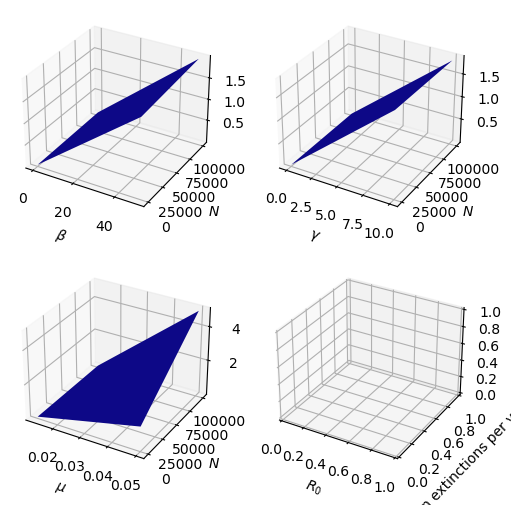

In [83]:
def analyse_extinctions(maxtime, n_runs, n_time_periods, *params_default_and_analysed):
    """Initialise and run multiple realisations of stochastic infection model with given ranges of parameters.
    Make 3 plots - beta/gamma/mu vs N vs Number of Extinctions.
    The args  *params contains a list of two dictionaries containing (1) the range of values to be analysed and
    (2) the default parameter values
    """

    params = params_default_and_analysed[0]
    defaults = params_default_and_analysed[1]

    d_params = {k: params[k] for k in ('beta', 'gamma', 'mu')}
    pop_range = params['N']

    d_param_keys = list(d_params.keys())

    ax_width = 3
    fig, axs = plt.subplots(2, 2, subplot_kw={'projection':'3d'})
    fig.set_size_inches(ax_width*2, ax_width*2)

    # DataFrame for storing R0 values
    df_r0 = pd.DataFrame(columns=['R0', 'N', 'Ext'])

    # Plot beta, gamma, mu
    param_key_ct = 0
    for d_param in d_params:

        print(f"Analysing parameter {d_param}")

        eym_runs = np.empty((len(d_params[d_param]), pop_range.shape[0], n_runs))

        param_ct = 0
        for d_param_value in d_params[d_param]:

            # Set model parameters
            if d_param == 'beta':
                beta = d_param_value
            else:
                beta = None
            if d_param == 'gamma':
                gamma = d_param_value
            else:
                gamma = None
            if d_param == 'mu':
                mu = d_param_value
            else:
                mu = None
            if d_param == 'Infectious Period':
                pinf = d_param_value
            else:
                pinf = defaults['pinf_def']
            if d_param == 'Lifespan':
                lifespan = d_param_value
            else:
                lifespan = defaults['lspan_def']

            for n in range(pop_range.shape[0]):

                n_pop = pop_range[n]
                
                # Perform multiple realizations of stochastic model
                for s in range(n_runs):
                    
                    np.random.seed(s)

                    # Create model instance
                    stochastic_SIR = InfectionModelStochasticImports(n_pop, 0, 0,
                                                            k=defaults['k_def'], c=defaults['c_def'], pinf=pinf, lifespan=lifespan,
                                                            beta=beta, gamma=gamma, mu=mu)

                    # Run model
                    time_track, X_track, Y_track, Z_track, N_track = stochastic_SIR.iterate(maxtime)
                    # print(f"Final population size: {stochastic_SIR.N}")
                    
                    # Identify extinctions
                    extinctions = [1 if Y_track[i]-Y_track[i-1] else 0 for i in range(1, len(Y_track))]
                    extinctions.insert(0, 0)

                    # Compartmentalise extinctions
                    extinctions_years = []
                    extinctions_year = []
                    year_ct = 1
                    for i in range(len(time_track)):
                        if time_track[i] <= maxtime*year_ct/n_time_periods:
                            extinctions_year.append(extinctions[i])
                        else:
                            extinctions_years.append(extinctions_year)
                            extinctions_year = [extinctions[i]]
                            year_ct += 1
                    extinctions_years.append(extinctions_year)

                    # Calculate mean extinctions per year
                    extinctions_year_total = [sum(ey) for ey in extinctions_years]
                    extinctions_year_mean = np.mean(np.array(extinctions_year_total))

                    eym_runs[param_ct, n, s] = extinctions_year_mean
                
                #print(eym_runs[param_ct, n, :])
                df_r0 = pd.concat([df_r0, pd.DataFrame([stochastic_SIR.R0, n_pop, np.mean(eym_runs[param_ct, n, :])])])

            param_ct += 1
        
        eym_means = np.mean(eym_runs, axis=2)
        param_grid, N_grid = np.meshgrid(d_params[d_param], pop_range)
        xlabel = "$\\" + d_param_keys[param_key_ct] + "$"

        axs[math.floor(param_key_ct*0.5)][param_key_ct%2].set_xlabel(xlabel)
        axs[math.floor(param_key_ct*0.5)][param_key_ct%2].set_ylabel('$N$')
        #axs[param_key_ct].yaxis.set_label_position("right")
        axs[math.floor(param_key_ct*0.5)][param_key_ct%2].plot_surface(param_grid, N_grid, eym_means, cmap=cm.plasma)

        param_key_ct += 1

    df_r0.sort_values(by=['R0', 'N'])
    print(df_r0)
    array_r0_data = df_r0.to_numpy()
    r0_grid = np.array(np.split(array_r0_data[0], n_param_samples))
    N_grid = np.array(np.split(array_r0_data[1], n_param_samples))
    ext_grid = np.array(np.split(array_r0_data[2], n_param_samples))
    print(r0_grid)
    print(N_grid)
    print(ext_grid)
    axs[-1][-1].set_xlabel('$R_0$')
    axs[-1][-1].set_ylabel('$N$')
    axs[-1][-1].set_ylabel('Mean extinctions per year')
    axs[-1][-1].plot_surface(r0_grid, N_grid, ext_grid, cmap=cm.plasma)

    plt.tight_layout(pad=2)

# Global simulation parameters
maxtime = 1095 # approx 3 years
n_runs = 1#0
n_param_samples = 2#0
n_time_periods = 1#3

# Dictionary of parameter values
params = {
    'N': np.linspace(100, 100000, n_param_samples),
    'beta': np.linspace(0.01, 50, n_param_samples),
    'gamma': np.linspace(0.01, 10, n_param_samples),
    'mu': np.linspace(1/80, 1/40, n_param_samples),
    # 'Infectious Period': np.linspace(0.1, 100, n_param_samples),
    # 'Lifespan': np.linspace(20, 80, n_param_samples)
}

defaults = {
    'n_def': 1000,
    'k_def': 8,
    'c_def': 0.1,
    'pinf_def': 7,
    'lspan_def': 60
}

analyse_extinctions(maxtime, n_runs, n_time_periods, params, defaults)

<a id='NetworkModels'></a>
### 2. Network Model

#### 2.1. Network Statistics



In [46]:
def plot_centrality_statistics(G, network_type, title_nodes=True):
    """Function to plot the centrality statistics.
    """
    
    # Calculate different centrality measures
    degree_centrality = nx.degree_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter = 1000)

    # Calculate average centrality values
    average_degree = sum(degree_centrality.values()) / len(degree_centrality)
    average_betweenness = sum(betweenness_centrality.values()) / len(betweenness_centrality)
    average_closeness = sum(closeness_centrality.values()) / len(closeness_centrality)
    average_eigenvector = sum(eigenvector_centrality.values()) / len(eigenvector_centrality)

    # Create subplots for the histograms
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(15, 4))

    # Create histograms for degree centrality
    ax1.hist(degree_centrality.values(), label='Degree Centrality')
    ax1.axvline(average_degree, color='r', linestyle='dashed', label='Average Degree Centrality')
    ax1.set_xlabel('Centrality Value')
    ax1.set_ylabel('Number of nodes')
    ax1.set_title('Degree Centrality')
    ax1.legend()

    # Create histograms for betweenness centrality
    ax2.hist(betweenness_centrality.values(), label='Betweenness Centrality')
    ax2.axvline(average_betweenness, color='r', linestyle='dashed', label='Average Betweenness Centrality')
    ax2.set_xlabel('Centrality Value')
    ax2.set_ylabel('Number of nodes')
    ax2.set_title('Betweenness Centrality')
    ax2.legend()

    # Create histograms for closeness centrality
    ax3.hist(closeness_centrality.values(), label='Closeness Centrality')
    ax3.axvline(average_closeness, color='r', linestyle='dashed', label='Average Closeness Centrality')
    ax3.set_xlabel('Centrality Value')
    ax3.set_ylabel('Number of nodes')
    ax3.set_title('Closeness Centrality')
    ax3.legend()

    # Create histograms for eigenvalue centrality
    ax4.hist(eigenvector_centrality.values(), label='Eigenvalue Centrality')
    ax4.axvline(average_eigenvector, color='r', linestyle='dashed', label='Average Eigenvalue Centrality')
    ax4.set_xlabel('Centrality Value')
    ax4.set_ylabel('Number of nodes')
    ax4.set_title('Eigenvalue Centrality')
    ax4.legend()


    title = f'Centrality Statistics for {network_type}'
    if title_nodes: title += f' with {nx.number_of_nodes(G)} nodes and {nx.number_of_edges(G)} edges'
    fig.suptitle(title, fontsize=15)
    plt.tight_layout()
    plt.subplots_adjust(top=0.8, bottom=0.15) 
    plt.subplots_adjust(wspace=0.4, hspace=0.4)
    plt.show()


#### 2.2. SIR on Different Network Types 

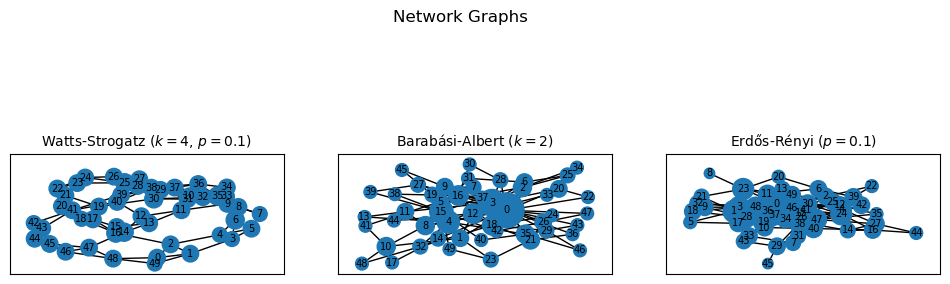

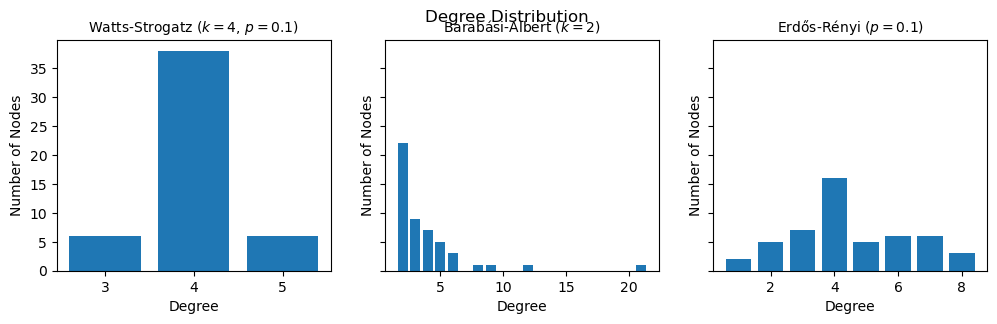

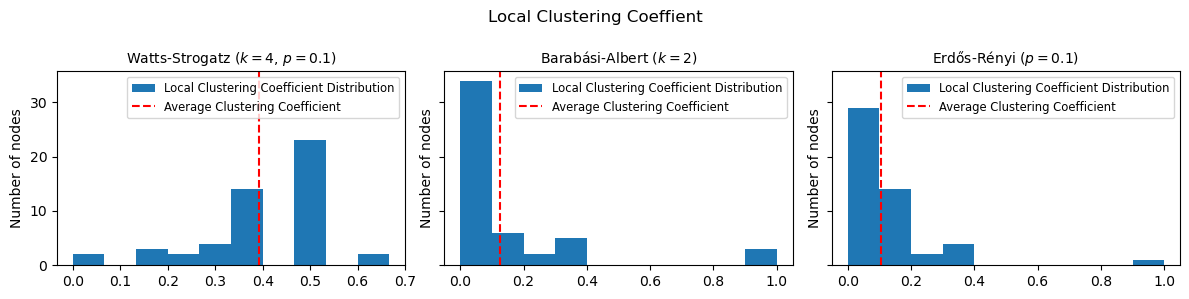

In [216]:
# Global variables
network_types = {'Watts-Strogatz': nx.watts_strogatz_graph,
                 'Barabási-Albert': nx.barabasi_albert_graph,
                 'Erdős-Rényi': nx.erdos_renyi_graph}
num_nodes = 50

# Watts-Strogatz parameters
k_ws = 4  # Each node is connected to k nearest neighbors
p_ws = 0.1  # Probability of rewiring each edge

# Barabási-Albert parameters
m_ba = 2  # Number of edges to attach from a new node to existing nodes

# Erdős-Rényi parameters
p_er = 0.1

# Visualise three types of network
fig1, axs1 = plt.subplots(1, 3, sharey=True)
fig2, axs2 = plt.subplots(1, 3, sharey=True)
fig3, axs3 = plt.subplots(1, 3, sharey=True)
axs = [axs1, axs2, axs3]
fig1.set_size_inches(len(network_types.keys())*4, 3)
fig2.set_size_inches(len(network_types.keys())*4, 3)
fig3.set_size_inches(len(network_types.keys())*4, 3)
fig1.suptitle("Network Graphs")
fig2.suptitle("Degree Distribution")
fig3.suptitle("Local Clustering Coeffient")
fig1.subplots_adjust(top=0.5, bottom=0.1)
type_ct = 0
for network_type in network_types:
    graph_gen = network_types[network_type]
    match network_type:
        case 'Watts-Strogatz':
            # Create a Watts-Strogatz small-world network
            G = graph_gen(num_nodes, k_ws, p_ws)
            params_label = f"$k={k_ws}$, $p={p_ws}$"
        case 'Barabási-Albert':
            # Create a Barabási-Albert scale-free network
            m = 2  # Number of edges to attach from a new node to existing nodes
            G = graph_gen(num_nodes, m_ba)
            params_label = f"$k={m}$"
        case 'Erdős-Rényi':
            # Create an Erdős-Rényi random graph
            G = graph_gen(num_nodes, p_er)
            params_label = f"$p={p_er}$"

    # Calculate and print degree distribution
    degree_sequence = np.array([d for _, d in G.degree()])
    degree_counts = dict(zip(*np.unique(degree_sequence, return_counts=True)))

    # Visualization: Network graph (for small networks)
    if num_nodes <= 100:
        pos = nx.spring_layout(G, iterations=100)
        nx.draw_networkx(G, pos,
                        node_size=(degree_sequence+1)*200/math.sqrt(num_nodes),
                        font_size=50/math.sqrt(num_nodes), with_labels=True, ax=axs[0][type_ct])
        axs[0][type_ct].set_title(f"{network_type} ({params_label})", fontsize='medium')
        
    # Visualization: Degree distribution
    axs[1][type_ct].bar(degree_counts.keys(), degree_counts.values())
    axs[1][type_ct].set_xlabel("Degree")
    axs[1][type_ct].set_ylabel("Number of Nodes")
    axs[1][type_ct].set_title(f"{network_type} ({params_label})", fontsize='medium')

    # plot_centrality_statistics(G, network_type)

    local_clustering_coefficient = nx.algorithms.cluster.clustering(G)
    av_local_clustering_coefficient = sum(local_clustering_coefficient.values()) / len(local_clustering_coefficient)
    axs[2][type_ct].hist(local_clustering_coefficient.values(), label = 'Local Clustering Coefficient Distribution')
    axs[2][type_ct].axvline(av_local_clustering_coefficient, color = 'r', linestyle = 'dashed', label = 'Average Clustering Coefficient')
    axs[2][type_ct].legend(fontsize='small')
    axs[2][type_ct].set_ylabel('Number of nodes')
    axs[2][type_ct].set_title(f'{network_type} ({params_label})', fontsize='medium')

    type_ct += 1

plt.tight_layout()
plt.show()

# Initialize the SIR model
model = sir(G)

# Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.03)  # Transmission rate
config.add_model_parameter('gamma', 0.01)  # Recovery rate
config.add_model_parameter("fraction_infected", 5/num_nodes)  # Initial fraction of infected nodes
model.set_initial_status(config)

# Simulation
n_iterations = model.iteration_bunch(200)  # Number of iterations
n_iterations2 = model.iteration_bunch(100)

# Implement a vaccination strategy


# Random Vaccination startegy.
# ============================================================================================
# vaccination_probability = 0.1  # Probability of vaccinating a node

# for i in range(num_nodes):
#     if random.random() < vaccination_probability:
#         model.status[i] = 2  # Mark node as "removed" (vaccinated)

# Vaccination strategy.
# ============================================================================================

# Get the results
trends = model.build_trends(n_iterations)

# # Plot the results
viz = DiffusionTrend(model, trends)
p = viz.plot()
show(p)

trends = model.build_trends(n_iterations2)

# # Plot the results
viz = DiffusionTrend(model, trends)
p = viz.plot()
show(p)

#### 2.2. Sociopatterns Network Data

### 3. Dynamic Vaccination Campaign

#### 2.3. Vaccination Strategy Prototype

<Axes: xlabel='time', ylabel='vals'>

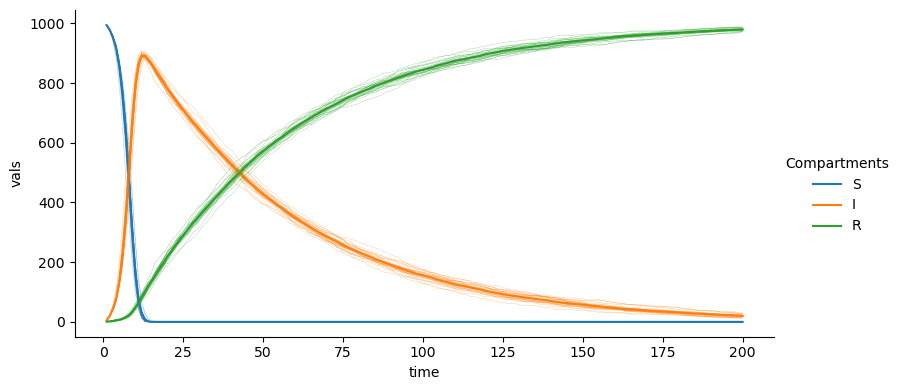

In [36]:
# Step 1: Create a network (you can replace this with your network creation code)
num_nodes = 1000
k = 4  # Each node is connected to k nearest neighbors
p = 0.1  # Probability of rewiring each edge
G = nx.watts_strogatz_graph(num_nodes, k, p)

# Step 2: Model Configuration
config = mc.Configuration()
config.add_model_parameter('beta', 0.76 )  # Transmission rate
config.add_model_parameter('gamma', 0.02)  # Recovery rate
config.add_model_parameter("fraction_infected", 5/num_nodes)  # Initial fraction of infected nodes

# Step 3: Simulate the SIR model with vaccination at every iteration
n_simulations = 20
n_iterations = 200
vaccination_probability = 0.84 # Probability of vaccine success
vaccination_budget = 1
testing_accuracy = 0.5

SIR_array = np.zeros((3, n_iterations + 1, n_simulations))
SIR_row_data = np.empty((n_simulations * n_iterations, 5))

for s in range(n_simulations):
    
    # generating the network 
    model = sir(G)
    model.set_initial_status(config)
    
    vaccinated_nodes, infected_nodes, removed_nodes = [], [], []
    
    tests_remaining = 200
    
    for i in range(1, n_iterations + 1):
        # Run iteration
        model.iteration()
        
        # Test and Vaccinate nodes at each iteration
        node_array = list(G.nodes())
        untested_nodes = [node for node in node_array if node not in vaccinated_nodes + infected_nodes + removed_nodes]
        # Untested nodes array can be modified according to centrality
        num_samples = (vaccination_budget if len(untested_nodes) > vaccination_budget else len(untested_nodes))
        tests_iteration = 30
        sample_num = 0
        test_num = 0
        while sample_num < num_samples and (test_num < tests_iteration and tests_remaining > 0) :
            # Performing the test
            node = random.sample(untested_nodes, 1)[0] # random selection of nodes
            # Implement ranking based on network statistics
            untested_nodes.remove(node)
            test_num += 1
            tests_remaining -= 1
            if (((model.status[node] == 0) | (model.status[node] == 2)) | ((model.status[node]) == 1 & (random.random() > testing_accuracy))):
                # Vaccinate if node is suspectible or test failed for infected
                # assuming vaccination doesn't work on infected
                model.status[node] = (2 if (model.status[node] != 1 and random.random() < vaccination_probability) else model.status[node]) 
                vaccinated_nodes.append(node)
                sample_num += 1
            else:
                infected_nodes.append(node)
        
        # Storing data for plotting
        SIR_counts = np.zeros(3)
        SIR_out = dict(zip(*np.unique(list(model.status.values()), return_counts=True)))
        for key in SIR_out: SIR_counts[key] = SIR_out[key]
        SIR_row_data[s * n_iterations + i - 1] = np.concatenate([np.array([s, i]), SIR_counts])

# Plot results from multiple simulations
df_SIR = pd.DataFrame(SIR_row_data, columns=['sim', 'time', 'S', 'I', 'R'])
df_SIR = df_SIR.melt(id_vars=['sim', 'time'], var_name='Compartments', value_name='vals')
sns.relplot(df_SIR, x='time', y='vals', kind='line', hue='Compartments', height=4, aspect=2.)
sns.lineplot(df_SIR, x='time', y='vals', hue='Compartments', style='sim', legend=False, linewidth=0.2)



#### 2.4. Sociopatterns Data

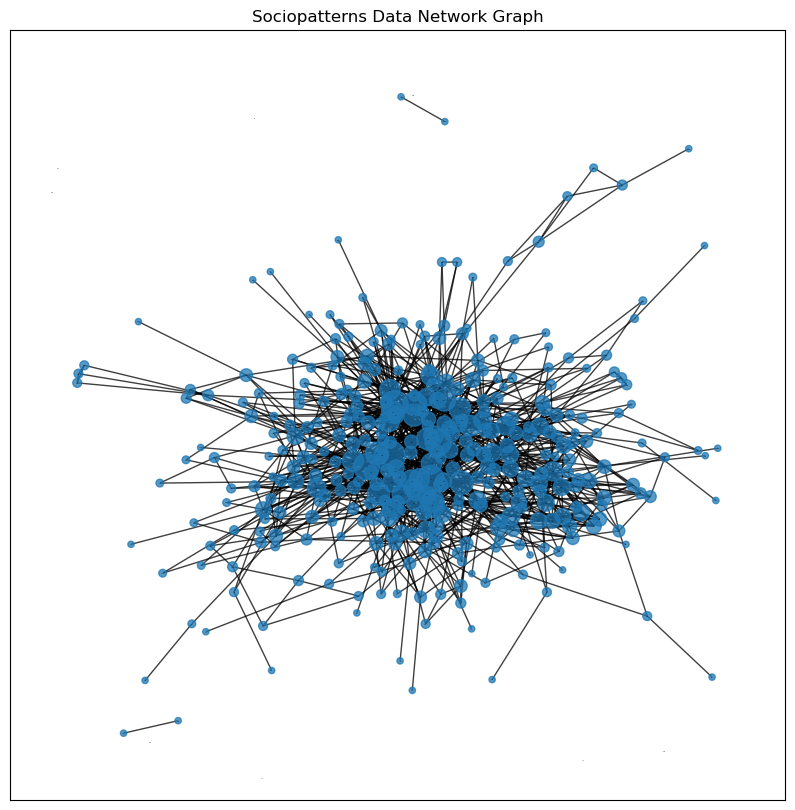

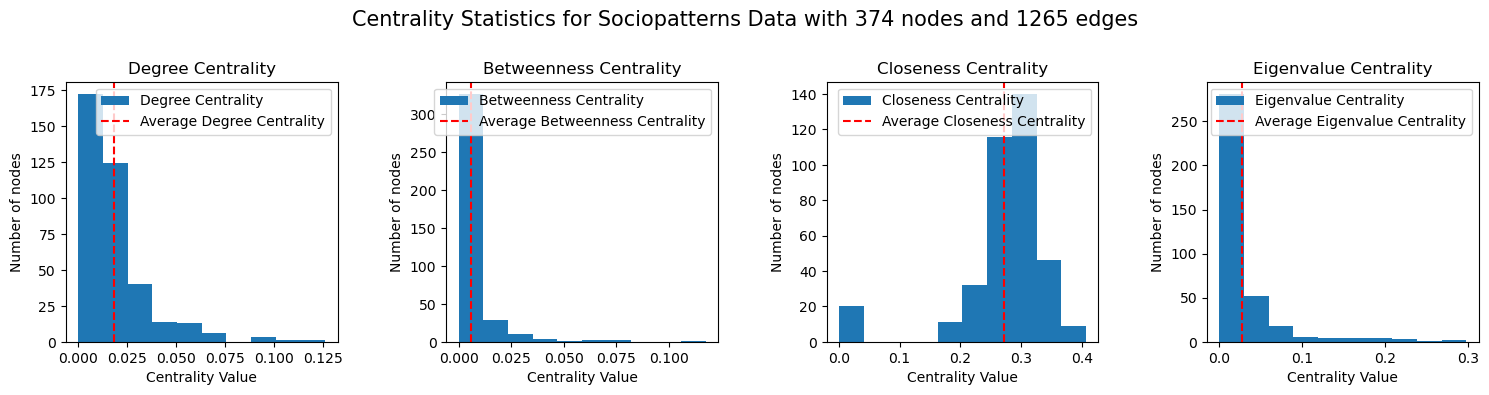

{0: [0], 1: [0, 1], 39: [0, 39], 56: [0, 56], 113: [0, 113], 162: [0, 162], 197: [0, 197], 213: [0, 213], 241: [0, 241], 74: [0, 1, 74], 106: [0, 1, 106], 138: [0, 1, 138], 168: [0, 1, 168], 177: [0, 1, 177], 185: [0, 1, 185], 240: [0, 1, 240], 114: [0, 39, 114], 186: [0, 39, 186], 189: [0, 39, 189], 36: [0, 56, 36], 47: [0, 56, 47], 49: [0, 56, 49], 51: [0, 56, 51], 58: [0, 56, 58], 104: [0, 56, 104], 277: [0, 56, 277], 336: [0, 56, 336], 234: [0, 162, 234], 353: [0, 162, 353], 365: [0, 162, 365], 26: [0, 197, 26], 29: [0, 197, 29], 40: [0, 197, 40], 151: [0, 197, 151], 163: [0, 197, 163], 184: [0, 197, 184], 193: [0, 197, 193], 196: [0, 197, 196], 20: [0, 213, 20], 108: [0, 213, 108], 214: [0, 213, 214], 4: [0, 241, 4], 178: [0, 241, 178], 11: [0, 1, 74, 11], 30: [0, 1, 138, 30], 90: [0, 1, 138, 90], 103: [0, 1, 138, 103], 110: [0, 1, 138, 110], 126: [0, 1, 138, 126], 194: [0, 1, 138, 194], 79: [0, 1, 168, 79], 82: [0, 1, 168, 82], 164: [0, 1, 168, 164], 165: [0, 1, 168, 165], 166: [

In [198]:
# Import the socio patterns network
network_df = pd.read_csv('transmission_network.csv',delimiter=";",index_col = 0)
# ignoring the weights.
network_df = network_df.applymap(lambda x: 1 if x != 0 else x)
# Create a Graph from the data frame values
G = nx.from_numpy_matrix(network_df.values)
num_nodes = nx.number_of_nodes(G)
num_edges = nx.number_of_edges(G)
network_type = 'Sociopatterns Data'

ax = plt.subplot()
ax.get_figure().set_size_inches(10, 10)
degree_sequence = [d for _, d in G.degree()]
nonzero_nodes = [n for n in G.nodes if G.degree(n) > 0]
nonzero_degrees = np.array([degree_sequence[n] for n in nonzero_nodes])
pos = nx.spring_layout(G, iterations=90, k=5/math.sqrt(num_nodes), scale=20, weight=2)
nx.draw_networkx(G, pos,
                node_size=(nonzero_degrees+1)*200/math.sqrt(num_nodes), nodelist=nonzero_nodes,
                font_size=0, with_labels=True, alpha=0.75, ax=ax)
plt.title("Sociopatterns Data Network Graph")
plt.show()
plot_centrality_statistics(G, network_type)

shortest_paths = dict(nx.all_pairs_shortest_path(G))
print(shortest_paths[0])

#### 2.5. Vaccination on Sociopatterns Network

In [ ]:
def sort_nodes(G):
    
    # Calculate network statistics
    degree_centrality = nx.degree_centrality(G)
    closeness_centrality = nx.closeness_centrality(G)
    betweenness_centrality = nx.betweenness_centrality(G)
    local_clustering_coefficient = nx.algorithms.cluster.clustering(G)
    eigenvector_centrality = nx.eigenvector_centrality(G, max_iter = 1000)

    # Create a DataFrame to store the network statistics
    Network_statistics = {
        'Degree Centrality': degree_centrality,
        'Closeness Centrality': closeness_centrality,
        'Betweenness Centrality': betweenness_centrality,
        'Eigen_vector Centrality': eigenvector_centrality,
        'Clustering Coefficient': local_clustering_coefficient,       
    }

    network_statistics_df = pd.DataFrame(Network_statistics)
    network_statistics_df = network_statistics_df.sort_values(by = ['Degree Centrality','Eigen_vector Centrality',
                                                                    'Clustering Coefficient','Betweenness Centrality',
                                                                     'Closeness Centrality'],ascending = [False, False, False,
                                                                                                          False, False])
    sorted_nodes = network_statistics_df.index
    return sorted_nodes